## Chaptor 7.5 부스팅 & Chaptor 7.6 스태킹 
- 화학데이터기반연구센터 양진훈 (2022.05.25)
- 참고자료: ageron handson-ml2 github 07번 jupyter ([Link](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb))

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

import numpy as np
import xgboost

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

### Chapter 7.5 부스팅 (Boosting)
- 약한 학습기(또는 예측기, 모델) 여러개를 연결하여 강한 학습기를 만드는 앙상블 방법.
- `AdaBoost` (adaptive boosting) 및 `Gradient Boosting`이 많이 사용됨.
- 새로운 예측기를 만드는 방법에서 차이를 보임.

#### 7.5.1 AdaBoost 
- 새로운 모델은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 학습함.
- 가중치가 높아질 때, 학습률 (`learning rate`)에 비례하여 높아짐
- 각 모델 (예측기)는 이전 모델이 훈련 및 평가되어야 학습할 수 있기 때문에 병렬화/분할이 불가능하여 확장성이 좋지 않음

##### 1) Moon 데이터셋 

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##### 2) Learning rate 변화에 따른 AdaBoost 모델의 결정 경계 변화

- Boundary plot을 위한 함수 선언

In [3]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    # 데이터 X는 2차원 데이터 (x1, x2)가 N개 모인 데이터로, 2D로 표현 가능함
    # x1: axes[0] ~ axes[1], x2: axes[2] ~ axes[3]
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    # x1, x2의 모든 페어 (100*100)를 2D로 표현하기 위해 grid 생성
    x1, x2 = np.meshgrid(x1s, x2s)
    # 2차원 데이터로 변환
    X_new = np.c_[x1.ravel(), x2.ravel()] # np.concatenate([...], axis=1) -> (N, 2)
    # 각 grid 좌표가 나타내는 X (x1, x2)에서의 y값 예측
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    # binary classification이기 때문에 2개의 영역이 나타남
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    # 경계선 표시
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    # 실제 데이터 표시
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

- `sklearn.svm.SVC`를 활용해 `AdaBoost` 알고리즘의 가중치 업데이트 정책에 따라 추가되는 모델들의 결정경계가 변하는 모습을 확인.

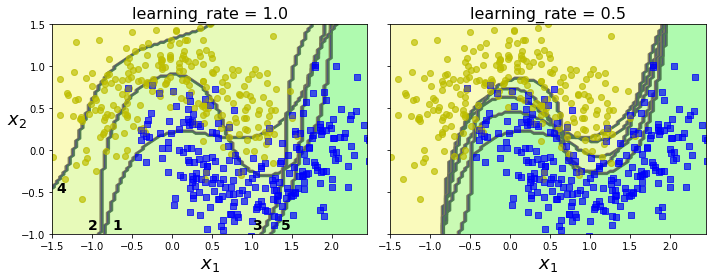

In [4]:
from sklearn.svm import SVC

# 학습률 list
learning_rates = [1.0, 0.5]

m = len(X_train)

fix, axes = plt.subplots(ncols=len(learning_rates), figsize=(5*len(learning_rates), 4), sharey=True)
for subplot, learning_rate in enumerate(learning_rates):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        # 모델 정의
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        # 계산해둔 weight로 초기화 후 학습
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        # 예측
        y_pred = svm_clf.predict(X_train)

        # 틀린 예측값에 대한 r_j 및 a_j 계산
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        # weight update
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0 and learning_rate == 1 and len(learning_rates) == 2:
        plt.text(-0.75, -0.95, "1", fontsize=14, weight='bold')
        plt.text(-1.05, -0.95, "2", fontsize=14, weight='bold')
        plt.text(1.0, -0.95, "3", fontsize=14, weight='bold')
        plt.text(-1.45, -0.5, "4", fontsize=14, weight='bold')
        plt.text(1.36,  -0.95, "5", fontsize=14, weight='bold')
    else:
        plt.ylabel("")
plt.tight_layout()

- 연속된 학습기법은 `Gradient Descent` 방법론과 유사하나, `Gradient Descent`는 ***모델의 파라미터***를 업데이트하여 비용함수를 최소화하는 반면, `AdaBoost`는 ***모델이 추가***된다는 점에서 차이를 보임.
- 앙상블의 종합적인 결과를 도출할 때 가중치가 사용됨.

##### 3) `AdaBoost`의 가중치 업데이트

\begin{equation}
r_j = \frac{
     \sum_{i=1}^{m} w^{(i)} \quad (\hat{y}_{j}^{(i)} \ne y^{(i)})
}{
     \sum_{i=1}^{m} w^{(i)}
}
\quad\quad (7.1)
\end{equation}

- 예측 값 ($\hat{y}_{j}^{(i)}$)이 원래 값 ($y^{(i)}$)과 다를 경우 가중치 ($w$)를 업데이트
- 새로운 가중치 ($\alpha_j$)는 다음과 같은 식을 이용해 계산 됨.
\begin{equation}
\alpha_j = \eta \log \frac{1-r_j}{r_j}
\quad\quad (7.2)
\end{equation}

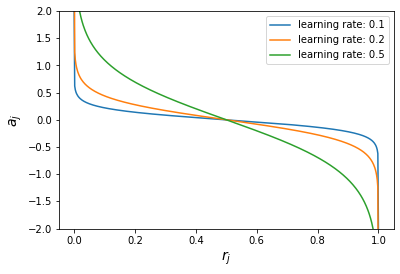

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

r_j = np.linspace(1e-9,1-1e-9,500)
for lr in [0.1, 0.2, 0.5]:
    a_j = lr*np.log((1-r_j)/(r_j)) # (7.2)
    plt.plot(r_j, a_j, label=f'learning rate: {lr}')
plt.ylim([-2,2])
plt.xlabel('$r_j$', fontsize=14)
plt.ylabel('$a_j$', fontsize=14)
plt.legend(loc='upper right')

- 예측기 성능에 따라
  - ***예측기가 정확할 때***: $r_j$는 `0`에 수렴하므로 $\alpha_j$는 `양`으로 발산.
  - ***무작위 예측에 가까울 때***: $r_j$는 `0.5`에 가까워지므로 $\alpha_j$는 `0`으로 수렴
  - ***예측기가 무작위 예측보다 못할 때***: $r_j$는 `1`에 수렴하므로 $\alpha_j$는 `음`으로 발산.
- 가중치 업데이트는 다음과 같은 정책에 따라 수행 됨
\begin{equation}
w^{(i)} = 
\begin{cases}
w^{(i)},&   (\hat{y}_{j}^{(i)} = y^{(i)})\\
w^{(i)} e^{(\alpha_j)}, &  (\hat{y}_{j}^{(i)} \ne y^{(i)})&
\end{cases}
\quad\quad(7.3)
\end{equation}
- 업데이트된 가중치는 $\sum_{i=1}^{m} w^{(i)}$로 나누어 정규화.
- 업데이트된 가중치로 새 모델 (예측기)이 훈련되며, 이러한 과정은 `1) 완벽한 모델이 훈련`되거나 `2) 지정된 모델 수에 도달`하면 종료됨.

##### 4) 최종 결과값 예측

- 모든 모델 (예측기)이 예측값을 계산하고, 예측기의 가중치 ($\alpha_j$)를 더해 예측 결과를 만듦.
- 가중치의 `합이 가장 큰 클래스`가 최종 예측 결과가 됨

##### 5) 예제

- `scikit-learn`에는 `SAMME` (`S`tagewise `A`dditive `M`odeling using a `M`ulticlass `E`xponential loss function)라는 다중 클래스 버전을 사용의 `AdaBoost`를 사용함. 
- 만약 클래스 확률을 추정할 수 있다면, `SAMME.R`을 활용할 수 있으며, 일반적으로 성능이 더 좋음.
- 클래스가 2개일 때에는 (7.1)~(7.3)과 동일한 식을 사용하지만, 클래스 (K)가 많아질 경우, 아래와 같이 변함.
\begin{equation}
    \alpha_j=\eta (\log \frac {1-r_j}{r_j} + \log (K-1))
\quad\quad\text{SAMME}
\end{equation}
\begin{equation}
    \alpha_j=-\eta \frac{K-1}{K}y \log \hat{p_j}
\quad\quad\quad\quad\quad\text{SAMME.R}
\end{equation}
- 예제는 `scikit-learn`에서 제공하는 `AdaBoostClassifier`를 활용하며, 깊이가 1인 200개의 결정트리를 사용함.

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [7]:
from sklearn.metrics import accuracy_score

y_pred = ada_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy of AdaBoost classifier: {:.3f}'.format(acc))

Accuracy of AdaBoost classifier: 0.896


정확도는 89.6%가 나오는 것을 확인할 수 있다.

#### 7.5.2 Gradient Boosting
- `AdaBoost`는 가중치를 수정한 모델을 추가하는 방식으로 앙상블을 완성하지만, `Gradient Boosting`은 이전 모델이 만든 **잔여 오차**에 새로운 예측기를 학습시킴.

##### 1) 예제
- 결정트리 기반 예측기를 활용해 회귀 (regression)문제를 풀 수 있으며 이를 `GBRT`(`G`radient `B`oosted `R`egression `T`ree)라고 부름.
- 데이터로는 noise가 섞인 2차함수를 활용

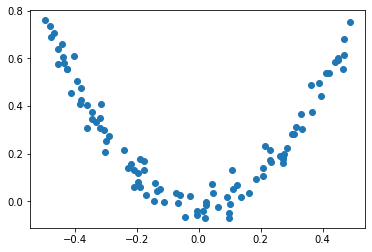

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
# x를 무작위로 생성한 후, 2차 다항식에 noise를 더해 y 생성
x = np.random.rand(100, 1) - 0.5
y = 3*x[:, 0]**2 + 0.05 * np.random.randn(100)

plt.scatter(x,y)

- 3개의 결정트리를 만들어 순차적으로 오차에 대해 학습시킴

In [9]:
from sklearn.tree import DecisionTreeRegressor

# 첫 번째 트리
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(x, y)
dy_t1 = y - tree_1.predict(x)
# 두 번째 트리
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_2.fit(x, dy_t1)
dy_t2 = dy_t1 - tree_2.predict(x)
# 세 번째 트리
tree_3 = DecisionTreeRegressor(max_depth=2)
tree_3.fit(x, dy_t2)
dy_t3 = dy_t2 - tree_3.predict(x)

trees  = [tree_1, tree_2, tree_3]
dys = [y, dy_t1, dy_t2]

- 최종 예측은 각 결정트리가 예측한 결과값들의 합으로 계산됨
```python
y_pred = np.sum([tree.prediction(x_test) for tree in trees], axis=0)
```
- 각 결정트리가 학습되면서 변하는 앙상블 합과 각 결정트리의 오차를 확인해보면 다음과 같음.


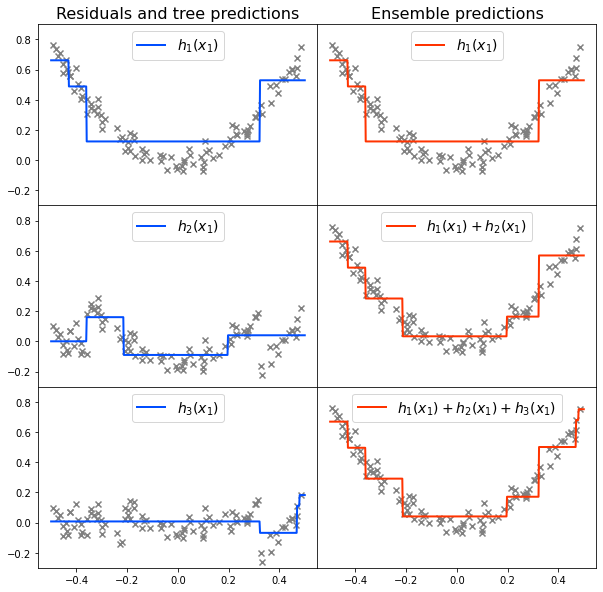

In [10]:
x_line = np.linspace(-0.5, 0.5, 500).reshape(-1,1)
f, axs = plt.subplots(3, 2, figsize=(10, 10))
labels = np.array([
    ['$h_1(x_1)$','$h_1(x_1)$'], 
    ['$h_2(x_1)$','$h_1(x_1)+h_2(x_1)$'], 
    ['$h_3(x_1)$','$h_1(x_1)+h_2(x_1)+h_3(x_1)$'], 
    ])
for i, tree in enumerate(trees):
    # 트리 모델
    y_tr_pred = tree.predict(x_line)
    axs[i,0].plot(x_line, y_tr_pred, color=[0,0.3,1], lw=2, label=labels[i,0])
    # residual
    axs[i,0].scatter(x, dys[i], marker='x', color=[0.5,0.5,0.5])
    # 앙상블 모델
    y_en_pred = np.sum([t.predict(x_line) for t in trees[:i+1]], axis=0)
    axs[i,1].plot(x_line, y_en_pred, color=[1,0.2,0], lw=2, label=labels[i,1])
    # 데이터
    axs[i,1].scatter(x, y, marker='x', color=[0.5,0.5,0.5])
    for ax in axs[i,:]:
        if i < 2: ax.set_xticks([])
        ax.legend(loc='upper center', fontsize=14)
        ax.set_ylim([-0.3,0.9])
    axs[i,1].set_yticks([])

axs[0,0].set_title('Residuals and tree predictions', fontsize=16)
axs[0,1].set_title('Ensemble predictions', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)    

- 앙상블이 추가됨에 따라 앙상블 합이 데이터를 더 잘 묘사하는걸 확인할 수 있음.
- `scikit-learn`을 활용해서 보다 간단하게 이를 재현할 수 있음

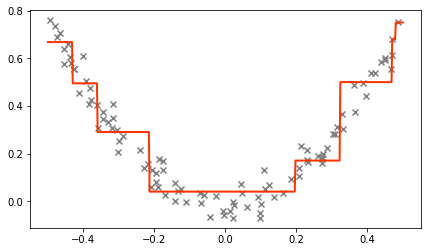

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(x,y)
y_line = gbrt.predict(x_line)

f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(x, y, color=[0.5, 0.5, 0.5], marker='x')
ax.plot(x_line, y_line, color=[1,0.2,0], lw=2)

- 학습률은 각 트리의 기여도를 조절하는 parameter로, 낮게 설정할수록 더 많은 트리가 필요하지면 예측 성능은 좋아짐; 축소 (shrinkage)라고 부르는 규제 방법.

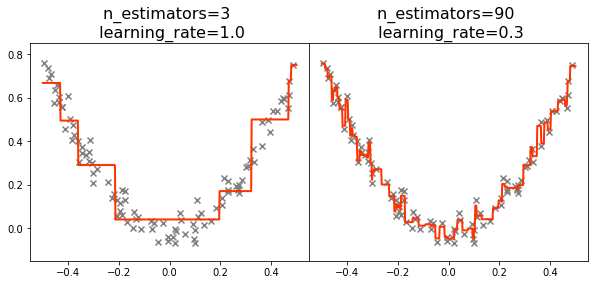

In [12]:
# Estimator의 수와 Learning rate의 pair로 구성된 list

estr_lr_pair = [(3, 1.0), (90, 0.3)] # 추가 가능

f, axs = plt.subplots(1, len(estr_lr_pair), figsize=(5*len(estr_lr_pair), 4))
for i, ax in enumerate(axs):
    # 데이터 
    ax.scatter(x, y, color=[0.5, 0.5, 0.5], marker='x')
    n_estr, lr = estr_lr_pair[i]
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=n_estr, learning_rate=lr)
    gbrt.fit(x,y)
    # 모델
    y_pred = gbrt.predict(x_line)
    ax.plot(x_line, y_pred, color=[1,0.2,0], lw=2)
    
    ax.set_title(f'n_estimators={n_estr} \n learning_rate={lr}', fontsize=16)
    ax.set_ylim([-0.15, 0.85])
    if i != 0: ax.set_yticks([])
plt.subplots_adjust(wspace=0)

- 왼쪽은 트리가 너무 적고, 오른쪽은 트리가 너무 많은 경우

##### 2) 최적의 트리 수 찾기
세 가지 방법으로 수행할 수 있음.
>- `GBRT`의 `staged_predict()`를 사용해 훈련한 트리들 중 비용함수가 최소가 되는 지점을 찾기
>- `warm_start = True`를 활용해 비용함수가 증가하는 지점을 찾고 훈련을 중지하기
>- `n_iter_no_change = True`를 활용해 훈련을 중지하기

a) `staged_predict()` 활용 예시

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=49)

# 다시 구현하기 위해 random state를 고정
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=128, random_state=42)
gbrt.fit(x_train, y_train)

# estimator가 증가했던 각 stage에 대해 x_valid를 이용해 prediction 수행
errors = [mean_squared_error(y_valid, y_pred) 
          for y_pred in gbrt.staged_predict(x_valid)]

# 에러 최저점 찾기
best_n_estr = np.argmin(errors) + 1
print('Best number of estimators: {}'.format(best_n_estr))

Best number of estimators: 56


In [14]:
# 모델을 다시 만들고 훈련
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estr, 
                                      random_state=42)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

- 최종 GBRT 및 에러 변화

Text(0, 0.5, '$y$')

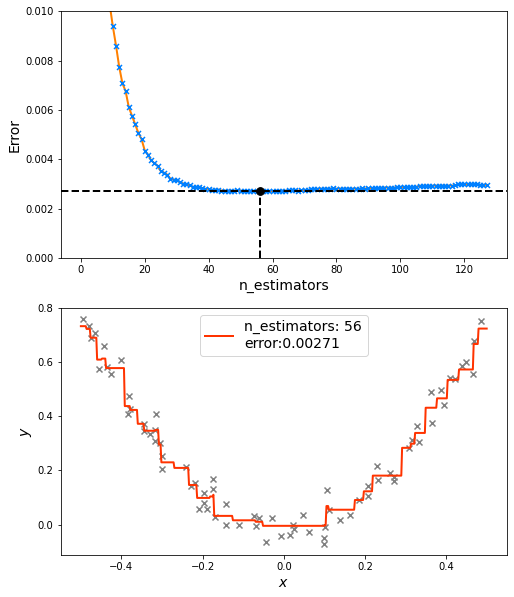

In [15]:
f, axs = plt.subplots(2, 1, figsize=(8,10))

## 에러 변화 그래프
# 모든 에러
axs[0].plot(range(len(errors)), errors, color=[1,0.5,0], lw=2)
axs[0].scatter(range(len(errors)), errors, color=[0,0.5,1], marker='x', s=25, zorder=50)
# 에러 최저점
axs[0].scatter(best_n_estr, errors[best_n_estr-1], color=[0,0,0], s=60, zorder=99)
axs[0].axhline(errors[best_n_estr-1], color=[0,0,0], ls='--', lw=2, zorder=80)
axs[0].vlines(best_n_estr, 0, errors[best_n_estr-1], color=[0,0,0], ls='--', lw=2, zorder=80)
axs[0].set_ylim([0,0.01])
axs[0].set_xlabel('n_estimators', fontsize=14)
axs[0].set_ylabel('Error', fontsize=14)

## 모델 그래프
y_line = gbrt_best.predict(x_line)
# 데이터
axs[1].scatter(x_train, y_train, color=[0.5, 0.5, 0.5], marker='x')
# 모델
axs[1].plot(x_line, y_line, color=[1,0.2,0], lw=2,
            label='n_estimators: {}\nerror:{:.5f}'.format(best_n_estr, errors[best_n_estr-1]))
axs[1].legend(loc='upper center', fontsize=14)
axs[1].set_xlabel('$x$', fontsize=14)
axs[1].set_ylabel('$y$', fontsize=14)

b) `warm_start`=`True` 활용 예시

In [16]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
# estimator의 수를 1개 부터 120개 까지 점차적으로 증가
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train, y_train)
    y_pred = gbrt.predict(x_valid)
    # 에러 계산
    val_error = mean_squared_error(y_valid, y_pred)
    # 계산된 에러가 최소점을 갱신할 경우
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    # 에러가 증가할 경우
    else:
        error_going_up += 1
        # 5회 이상 증가하면 정지
        if error_going_up == 5:
            break  # early stopping

print('n_estimators: {}'.format(gbrt.n_estimators - 5))
print('error: {:.5f}'.format(min_val_error))

n_estimators: 56
error: 0.00271


c) `n_iter_no_change` 활용 예시
- 이 기능은 `scikit-learn` 0.2 버전부터 추가된 기능으로, train 데이터 중 10% (기본값)를 validation으로 활용하여 `n_iter_no_change`반복 동안 `tol`값이 $10^{-4}$이상 향상되지 않으면 정지함
- 사용 가능한 `Loss`는 `squared_error` (기본값), `absolute_error`, `huber`, `quantile` 등이 있음.

In [17]:
gbrt = GradientBoostingRegressor(max_depth=2, n_iter_no_change=5, random_state=42)
gbrt.fit(x_train, y_train)

y_pred = gbrt.predict(x_valid)
err = mean_squared_error(y_valid, y_pred)

print('n_estimators: {}'.format(gbrt.n_estimators_))
print('error: {:.5f}'.format(err))

n_estimators: 48
error: 0.00276


- `GradientBoostingRegressor`는 `subsample` 매개변수를 이용해 무작위로 선택된 일부 데이터만을 이용해 학습하는 기능을 지원하며, 이는 `stochastic gradient boosting`이라고 함. 
- 훈련 속도를 높이고 과적합을 방지할 수 있음.

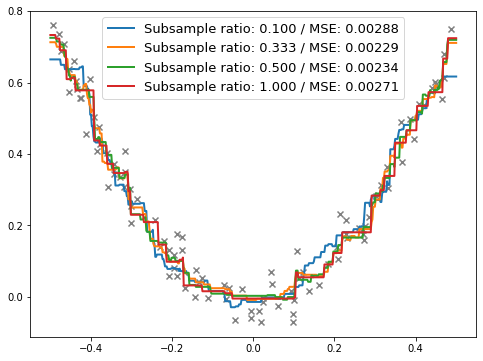

In [18]:
# subsample 비율
rs = [0.1, 0.333, 0.5, 1]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(x, y, marker='x',color=[0.5, 0.5, 0.5])
for r in rs:
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42, subsample=r)
    gbrt.fit(x_train, y_train)

    # 에러 계산
    y_pred = gbrt.predict(x_valid)
    err = mean_squared_error(y_valid, y_pred)

    # 모델
    y_line = gbrt.predict(x_line)
    ax.plot(x_line, y_line, lw=2, label='Subsample ratio: {:.3f} / MSE: {:.5f}'.format(r, err))
ax.legend(loc='upper center', fontsize=13)

##### 3) XGBoost ([Link](https://github.com/dmlc/xgboost))
- E`X`treme `G`radient `Boost`ing의 약자로, 빠르고 확장성/이식성이 우수하여 많이 사용됨.

[04:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

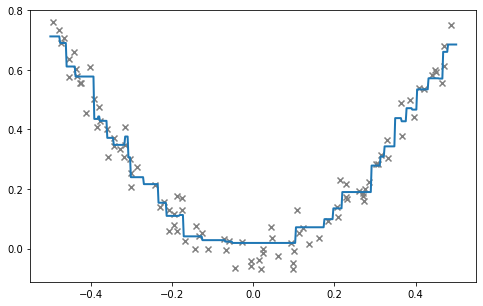

In [19]:
import xgboost
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# 2차 함수 데이터 생성
x = np.random.rand(100, 1) - 0.5
y = 3*x[:, 0]**2 + 0.05 * np.random.randn(100)

# 모델 예측 결과를 그리기 위한 x값
x_line = np.linspace(-0.5, 0.5, 500).reshape(-1,1)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=49)

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=2)
y_line = xgb_reg.predict(x_line)

f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x, y, marker='x',color=[0.5, 0.5, 0.5])
ax.plot(x_line, y_line, lw=2)

##### 4) LightGBM ([Link](https://lightgbm.readthedocs.io))
- Histogram을 기반으로한 gradient boosting 방법론으로, `scikit-learn`으로 간단하게 활용 가능함

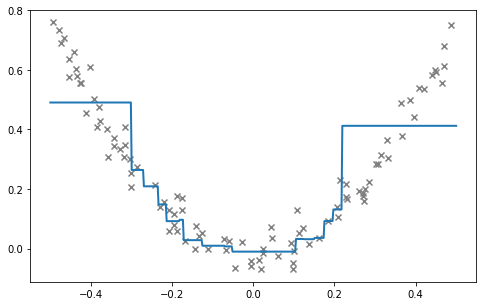

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor()
hgbr.fit(x_train, y_train)
y_line = hgbr.predict(x_line)

f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x, y, marker='x',color=[0.5, 0.5, 0.5])
ax.plot(x_line, y_line, lw=2)

### Chapter 7.6 스태킹 (Stacked generalization)
- 앙상블에 포함된 모든 모델을 취합하는 함수를 훈련시킴.
- 취합하는 모델을 `Blender` 또는 `meta learner`라고도 부르며, `hold-out` 및 `out-of-fold` 두 가지 예측법이 있음
- `Hold-out` 세트를 활용할 경우 `Blanding`이라고 함.
- `Out-of-fold` 세트를 활용할 경우 `Stacking`이라고 함.
- 많은 경우 `Blending`과 `Stacking`을 혼용해서 부름.
- `Stacking`은 `k-fold validation`에서 `validation fold`의 결과값만을 모은걸 말함.

#### 1) `Blending` 방법
>1. 데이터 셋을 두 개로 나누고 (`A`, `B`), `A` 데이터셋을 이용해 앙상블을 훈련시킴.
>2. 훈련된 앙상블로 `B` 데이터셋에 대해 예측을 수행함.
>3. 해당 예측을 이용해 타겟값을 예측하는 모델 (`blender`)을 훈련시킴.

- 이러한 `blender`를 여러개 만들어 하나의 레이어로 활용할 수 있음 (총 3층; 모델 앙상블 / 블렌더 앙상블 / 블렌더)
- 이런 경우 훈련 세트를 세 개로 나누고 (`A`, `B`, `C`),
  - `A` 세트는 모델 앙상블을 훈련시키는데 사용
  - 모델 앙상블로 `B` 세트에 대해 예측을 수행하여, 블렌더 앙상블을 훈련하는데 사용
  - 블렌더 앙상블로 `C` 세트에 대해 예측을 수행하여, 마지막 블렌더를 훈련시키는데 사용

In [21]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=5000, noise=0.30, random_state=42)
# 테스트를 위해 데이터를 세개로 분리
X_set1, X_set2, X_test = X[:2000], X[2000:4000], X[4000:]
y_set1, y_set2, y_test = y[:2000], y[2000:4000], y[4000:]

`RandomForestClassifier`, `ExtraTreesClassifier`, `LinearSVC`, `MLPClassifier` 네 개의 모델로 이루어진 앙상블을 만들고, `X_set1`으로 훈련. 평가는 `X_test`로 진행

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import f1_score

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=41)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=41)
svm_clf = LinearSVC(max_iter=50, tol=10, random_state=41)
mlp_clf = MLPClassifier(tol=0.01, random_state=41)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    estimator.fit(X_set1, y_set1)

y_preds = [estr.predict(X_test) for estr in estimators]
for y_pred, estr in zip(y_preds, estimators):
    print("Score: {:.3f} from estimator: {}".format(np.average(y_pred == y_test), estr))

Score: 0.891 from estimator: RandomForestClassifier(random_state=41)
Score: 0.890 from estimator: ExtraTreesClassifier(random_state=41)
Score: 0.781 from estimator: LinearSVC(max_iter=50, random_state=41, tol=10)
Score: 0.850 from estimator: MLPClassifier(random_state=41, tol=0.01)


`RandomForestClassifier`로 `blender`를 만들고 `X_set2`에 대해 앙상블이 예측한 결과를 훈련 데이터로 사용. 평가는 `X_test`로 진행

In [23]:
rfc_blender = RandomForestClassifier(n_estimators=100, random_state=41)
x_blender = np.array([estr.predict(X_set2) for estr in estimators]).T # (4,N) -> (N,4)
rfc_blender.fit(x_blender, y_set2)

y_pred = rfc_blender.predict(np.array(y_preds).T) 
print("Score: {:.3f} from blender: {}".format(np.average(y_pred == y_test), rfc_blender))

Score: 0.896 from blender: RandomForestClassifier(random_state=41)
